# BM3 GNN Pred

In [1]:
from typing import *
import numpy as np
from functools import partial

import torch
from torch import Tensor, nn
import torch.nn.functional as F

from tomopt.volume import *
from tomopt.muon import *
from tomopt.inference import *
from tomopt.optimisation import *
from tomopt.core import *
from tomopt.utils import *
from tomopt.plotting import *

In [2]:
DEVICE = torch.device("cpu")

In [3]:
from tomopt.volume.layer import Layer

def get_volume(size: float = 0.2, lwh: Tensor = Tensor([1.0, 1.0, 1.4]), device: torch.device = torch.device("cpu")) -> Volume:
    def area_cost(x: Tensor) -> Tensor:
        return F.relu(x)

    layers: List[Layer] = []
    n_panels = 4
    layers.append(
        PanelDetectorLayer(
            pos="above",
            lw=lwh[:2],
            z=lwh[2].item(),
            size=size,
            panels=[
                DetectorPanel(
                    res=1e3, eff=1, init_xyz=(lwh[0].item()/2, lwh[1].item()/2, lwh[2].item() - (i * (size) / n_panels)), init_xy_span=(lwh[0].item(), lwh[1].item()), area_cost_func=area_cost, device=device
                )
                for i in range(n_panels)
            ],
        )
    )
    for z in np.round(np.arange(lwh[2] - size, size, -size), decimals=1):
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=device))
    layers.append(
        PanelDetectorLayer(
            pos="below",
            lw=lwh[:2],
            z=size,
            size=size,
            panels=[
                DetectorPanel(
                    res=1e3, eff=1, init_xyz=(lwh[0].item()/2, lwh[1].item()/2, size - (i * (size) / n_panels)), init_xy_span=(lwh[0].item(), lwh[1].item()), area_cost_func=area_cost, device=device
                )
                for i in range(n_panels)
            ],
        )
    )

    return Volume(nn.ModuleList(layers))

In [4]:
volume = get_volume(device=DEVICE)

In [5]:
muons = MuonBatch(generate_batch(250), init_z=volume.h, device=DEVICE)

In [6]:
gen = RandomBlockPassiveGenerator(
        block_size=None, volume=volume, sort_x0=False, enforce_diff_mat=True, materials=["beryllium", "carbon", "silicon", "iron", "lead"], block_size_max_half=False
    )

In [7]:
volume.load_rad_length(*gen.get_data())

In [8]:
volume(muons)

In [9]:
volume.target

tensor([0.0937])

sb = ScatterBatch(muons, volume)

In [10]:
sb = GenScatterBatch(muons, volume)

## GNN inferer

In [11]:
model = torch.jit.load('../../mode_muon_tomo_inference/dev/exported_models/bm3_traced.pt')

In [12]:
type(model)

torch.jit._script.RecursiveScriptModule

In [13]:
from tomopt.inference.scattering import ScatterBatch

class GenDeepVolumeInferer(DeepVolumeInferer):
    def get_base_predictions(self, scatters: ScatterBatch) -> Tuple[Tensor, Tensor]:
        x = self.base_inferer._x0_from_dtheta(delta_z=self.size, mom=scatters.mu.reco_mom, dtheta=scatters.dtheta, theta_xy_in=scatters.theta_in, theta_xy_out=scatters.theta_out)[:, None]
        return x, torch.zeros_like(x)
    
    def add_scatters(self, scatters: ScatterBatch) -> None:
        self.scatter_batches.append(scatters)
        x0, x0_unc = self.get_base_predictions(scatters)
        self.in_vars.append(torch.cat((scatters.dtheta, scatters.dxy, x0, scatters.location), dim=-1))
        self.efficiencies.append(self.compute_efficiency(scatters=scatters))
        
    def get_prediction(self) -> Tuple[Optional[Tensor], Optional[Tensor]]:
        self.in_var = torch.cat(self.in_vars, dim=0)
        self.efficiency = torch.cat(self.efficiencies, dim=0)

        inputs = self._build_inputs(self.in_var)
        pred = self.model(inputs[None])
        weight = self._get_weight()
        return pred, weight

In [14]:
dvi = GenDeepVolumeInferer(model=model, base_inferer=PanelX0Inferer(volume), volume=volume)

In [15]:
dvi.in_vars, dvi.in_var_uncs

([], [])

In [16]:
dvi.add_scatters(sb)

/Users/giles/cernbox/mode_muon_tomography/tomopt/inference/volume.py:295: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  c = torch.combinations(torch.arange(0, len(effs)), r=r)


In [17]:
dvi.in_vars[0].shape

torch.Size([250, 8])

In [18]:
%%time
p,w = dvi.get_prediction()

CPU times: user 3.8 s, sys: 395 ms, total: 4.2 s
Wall time: 1.6 s


In [19]:
torch.exp(p).shape

torch.Size([1, 5, 125])

In [20]:
p

tensor([[[-1.9752e-01, -4.6779e-01, -6.3622e-01, -5.1529e-01, -2.5647e-01,
          -5.0483e-01, -1.1662e+00, -1.3485e+00, -1.0049e+00, -4.5226e-01,
          -8.1904e-01, -1.6689e+00, -1.7476e+00, -1.2440e+00, -4.9187e-01,
          -7.6290e-01, -1.5242e+00, -1.5432e+00, -1.0105e+00, -3.3636e-01,
          -4.1822e-01, -8.0745e-01, -8.0789e-01, -4.6245e-01, -1.5363e-01,
          -2.4569e-01, -6.8067e-01, -9.3820e-01, -7.0351e-01, -3.0838e-01,
          -7.1474e-01, -1.6976e+00, -2.0126e+00, -1.4982e+00, -6.0254e-01,
          -1.1598e+00, -2.2697e+00, -2.5043e+00, -1.8670e+00, -7.3566e-01,
          -1.0726e+00, -2.1020e+00, -2.2453e+00, -1.5554e+00, -5.6030e-01,
          -5.9221e-01, -1.2109e+00, -1.3136e+00, -7.5470e-01, -2.2158e-01,
          -1.4328e-01, -3.8873e-01, -5.5423e-01, -3.7743e-01, -1.3265e-01,
          -3.9223e-01, -1.1227e+00, -1.4550e+00, -1.0167e+00, -3.1228e-01,
          -6.7442e-01, -1.5874e+00, -1.9324e+00, -1.3432e+00, -4.3661e-01,
          -6.0901e-01, -1

In [21]:
%%time
# jacobian(p, dvi.in_var)  # crashes

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.77 µs


## Loss

In [22]:
x02id = {X0[m]: i for i, m in enumerate(gen.materials)}; x02id

{0.3528: 0, 0.1932: 1, 0.0937: 2, 0.01757: 3, 0.005612: 4}

In [23]:
loss = VoxelClassLoss(x02id=x02id, target_budget=None)

In [24]:
l = loss(p, 1, volume); l

Automatically setting cost coefficient to 0.6329460740089417


tensor([0.6329], grad_fn=<AddBackward0>)

## Plotting

In [25]:
class_preds = p.argmax(1).detach().cpu().numpy()

In [26]:
true = volume.get_rad_cube().flatten().reshape((5,5,5))

In [27]:
class_preds = class_preds.reshape(true.shape)

In [28]:
id2x0 = {v:k for k,v in x02id.items()}; id2x0

{0: 0.3528, 1: 0.1932, 2: 0.0937, 3: 0.01757, 4: 0.005612}

In [29]:
def class_to_x0preds(array: np.ndarray, id2x0: Dict[int, float]) -> np.ndarray:
    x0array = np.zeros_like(array, dtype='float32')
    for i in np.unique(array):
        x0array[array == i] = id2x0[i]
    return x0array

In [30]:
x0_preds = class_to_x0preds(class_preds, id2x0)

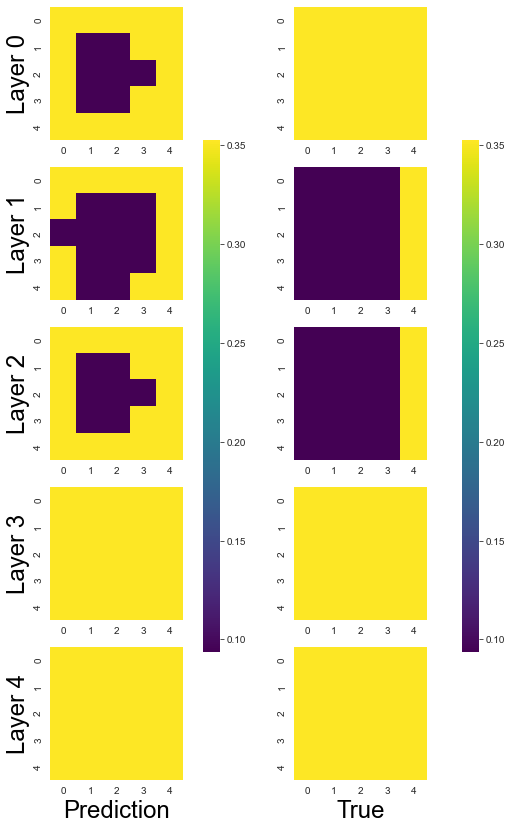

In [31]:
plot_pred_true_x0(x0_preds, true)

In [32]:
def x0targs_to_classtargs(array: np.ndarray, x02id: Dict[float, int]) -> np.ndarray:
    x0array = np.zeros_like(array)
    for i in np.unique(array):
        x0array[array == i] = x02id[min(x02id, key=lambda x:abs(x-i))]
    return x0array

In [33]:
x02id

{0.3528: 0, 0.1932: 1, 0.0937: 2, 0.01757: 3, 0.005612: 4}

In [34]:
class_targs = x0targs_to_classtargs(true, x02id)

In [35]:
class_targs

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[2., 2., 2., 2., 0.],
        [2., 2., 2., 2., 0.],
        [2., 2., 2., 2., 0.],
        [2., 2., 2., 2., 0.],
        [2., 2., 2., 2., 0.]],

       [[2., 2., 2., 2., 0.],
        [2., 2., 2., 2., 0.],
        [2., 2., 2., 2., 0.],
        [2., 2., 2., 2., 0.],
        [2., 2., 2., 2., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]], dtype=float32)

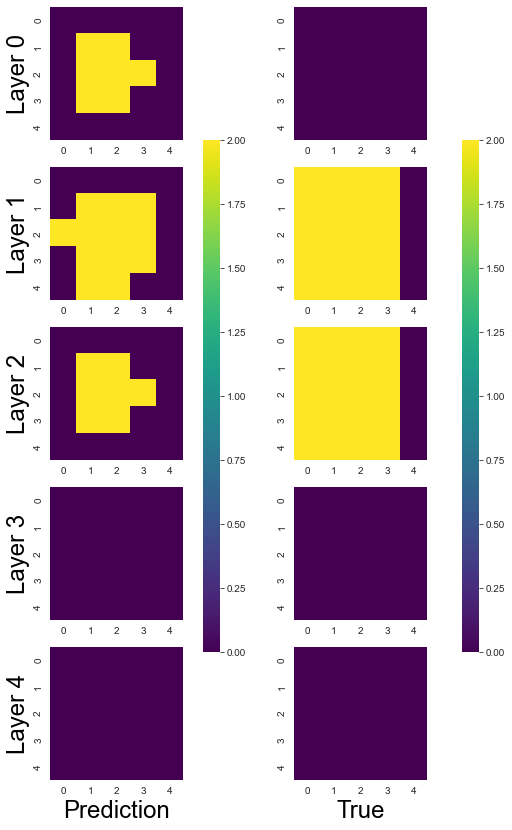

In [36]:
plot_pred_true_x0(class_preds, class_targs)